Setup

In [1]:
# Attention based Neural Networks
from attention import Attention
from keract import get_activations

import itertools
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas
from sklearn.preprocessing import MinMaxScaler

# Time Series related methods (generation and analysis)
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels

# PCMCI
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

import time
import warnings

times = {}

In [2]:
# Applies the Granger Causality Test between two Variables
def granger_causality_test(data, maxlag, verbose):
    test_results = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    p_values = []
    for lag in range(1, maxlag + 1):
        p_values.append(test_results[lag][0]['ssr_chi2test'][1])
    return min(p_values)

# Calculates and Outputs a Matrix consisting of a Granger Causality Test
# for each pair of Variables, where values below 0.05 indicate that the
# Variable of the Column can be used to predict the Variable of the Row
def granger_causality_matrix(data, maxlag=10, plot=False):
    cols = len(data.columns)
    matrix = np.zeros([cols, cols])
    for i, row in enumerate(data.columns):
        for j, col in enumerate(data.columns):
            matrix[i, j] = granger_causality_test(data[[row, col]], maxlag, False)
    if plot:
        plt.imshow(matrix)
        plt.colorbar()
        plt.show()
    return matrix

# Receives a Causality Matrix as Input and Outputs a Matrix where
# Values below alpha are replaced by 1 and 0 otherwise
def filter_causality_matrix(matrix, alpha, plot=False):
    filtered_matrix = np.zeros(matrix.shape)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if matrix[i, j] < alpha:
            filtered_matrix[i, j] = 1
    if plot:
        plt.imshow(filtered_matrix, cmap='Greens')
        plt.colorbar()
        plt.show()
    return filtered_matrix

def graph_from_matrix(matrix, names=None):
    G = nx.DiGraph()
    if names is None:
      names = np.arange(1, len(matrix) + 1)
    G.add_nodes_from(names)
    nodes = list(G.nodes)
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
        if  matrix[i, j] == 1:
          G.add_edge(nodes[j], nodes[i])
    nx.draw(G, with_labels=True, connectionstyle='arc3, rad=0.05', node_size=1000, node_color='beige')
    plt.show()

Generate Dataset

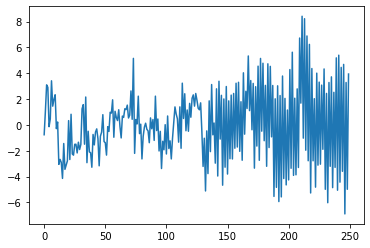

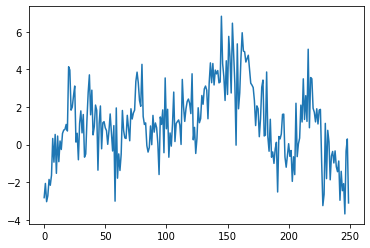

In [3]:
n = 250

# Fix dataset
np.random.seed(42)

ar_1 = np.array([-0.25, 0.75])
ar_1 = np.r_[1, -ar_1]
ma_1 = np.array([0.8, 0.2])
ma_1 = np.r_[1, ma_1]

X1 = arma_generate_sample(ar_1, ma_1, n)
# Add noise to prevent perfect predictions
X1 += np.random.normal(0, 1, n)

plt.plot(X1)
plt.show()

empty_inp = np.zeros(150)
x2_model = SARIMAX(empty_inp, order=(3, 0, 1), seasonal_order=(0, 0, 0, 0))
X2 = x2_model.simulate([0.4, 0.3, 0.2, 0.3, 0.5, 0.2, 0.3, 0.15, 0.1], n)
# Add noise to prevent perfect predictions
X2 += np.random.normal(0, 1, n)

plt.plot(X2)
plt.show()

First Dataset: Linear Dependencies

Expected Graph:

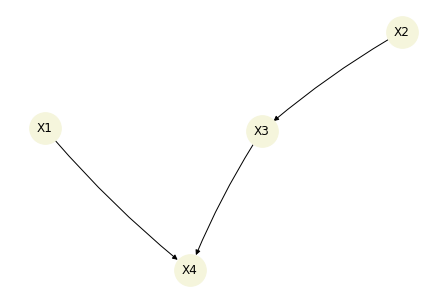

In [4]:
graph_from_matrix(np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 1, 0, 0], [1, 0, 1, 0]]), ['X1', 'X2', 'X3', 'X4'])

In [5]:
X3 = np.zeros(n)
X4 = np.zeros(n)

for i in range(1, n):
  X3[i] = 3 * X2[i - 1]
  X4[i] = 2 * X3[i - 1] + X1[i - 1]

np.random.seed(0)

test1 = pandas.DataFrame()
test1['X1'] = X1
test1['X2'] = X2
# Add noise to prevent perfect predictions
test1['X3'] = X3 + np.random.normal(0, 1, n)
# Add noise to prevent perfect predictions
test1['X4'] = X4 + np.random.normal(0, 1, n)

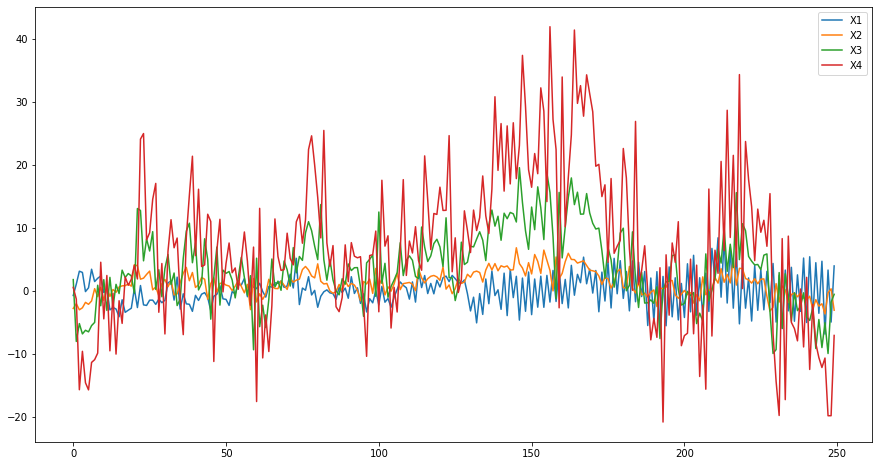

In [6]:
test1.plot(figsize=(15, 8))
plt.show()

In [7]:
def adf_test(data):
  for col in data.columns:
    results = adfuller(data[col])
    print("-----------------")
    print(col)
    print("ADF Value:", results[0])
    print("P-Value:", results[1])
    print("Critical Values:")
    for key in results[4].keys():
      print(key, results[4][key])

In [8]:
adf_test(test1)

-----------------
X1
ADF Value: -4.012514918301403
P-Value: 0.0013463787375262493
Critical Values:
1% -3.457437824930831
5% -2.873459364726563
10% -2.573122099570008
-----------------
X2
ADF Value: -3.0491585331735247
P-Value: 0.030551712493302078
Critical Values:
1% -3.457215237265747
5% -2.873361841566324
10% -2.5730700760129555
-----------------
X3
ADF Value: -3.0709961427362744
P-Value: 0.028775399052256085
Critical Values:
1% -3.457215237265747
5% -2.873361841566324
10% -2.5730700760129555
-----------------
X4
ADF Value: -3.0470094389991647
P-Value: 0.030731467073889934
Critical Values:
1% -3.4573260719088132
5% -2.873410402808354
10% -2.573095980841316


PCMCI

In [9]:
def run_pcmci(df, tau_max=8, verbose=False):
  dataframe_1 = pp.DataFrame(test1.values, datatime=np.arange(len(test1)))
  if verbose:
    tp.plot_timeseries(dataframe_1)

  start_time = time.perf_counter()

  parcorr = ParCorr(significance='analytic')
  pcmci = PCMCI(
    dataframe=dataframe_1,
    cond_ind_test=parcorr,
    verbosity=1)
  if verbose:
    correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
    lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names': ['X1', 'X2', 'X3', 'X4'],
                                      'x_base':5, 'y_base':.5})
    plt.show()
  pcmci.verbosity = int(verbose)
  results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
  q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
  if verbose:
    pcmci.print_significant_links(
      p_matrix = results['p_matrix'],
      q_matrix = q_matrix,
      val_matrix = results['val_matrix'],
      alpha_level = 0.01)
  link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

  end_time_pcmci_linear = time.perf_counter() - start_time

  tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=['X1', 'X2', 'X3', 'X4'],
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()
  
  return end_time_pcmci_linear

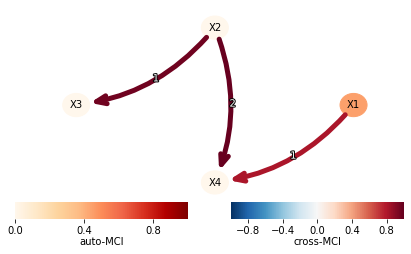

In [10]:
end_time_pcmci_linear = run_pcmci(test1, tau_max=20)

times['pcmci_linear'] = end_time_pcmci_linear

Granger Causality (Exhaustive Approach)

In [11]:
start_time = time.perf_counter()

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  matrix = granger_causality_matrix(test1, maxlag=5)
  filtered_matrix = filter_causality_matrix(matrix, 0.05)

end_time_granger_linear = time.perf_counter() - start_time
times['granger_linear'] = end_time_granger_linear

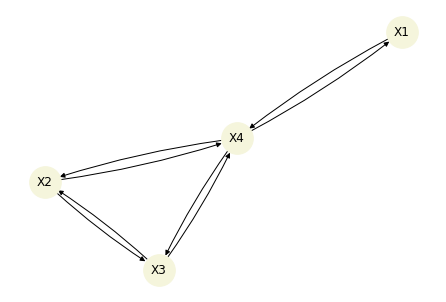

In [12]:
graph_from_matrix(filtered_matrix, ['X1', 'X2', 'X3', 'X4'])

Neural Networks with Gradient Information

In [13]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [14]:
def gradient_importance(seq, model):
  #seq = tensorflow.Variable(seq[np.newaxis,:,:], dtype=tensorflow.float32)

  with tensorflow.GradientTape() as tape:
    predictions = model(seq)
  
  grads = tape.gradient(predictions, seq)
  grads = tensorflow.reduce_mean(grads, axis=1).numpy()[0]

  return grads

In [15]:
values = test1.values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

def series_to_supervised(data, order, split, val_split=0):
  df = pandas.DataFrame(data)
  for col in df.columns:
    df = df.rename(columns = {col: 'var' + str(col)})
  
  shifts = {}
  shifts['+1'] = df.shift(-1)

  if order > 0:
    for i in range(1, order + 1):
      shifts['-' + str(i)] = df.shift(i)
  for key in shifts.keys():
    for col in shifts[key].columns:
      df[str(col) + key] = shifts[key][col]

  df = df.dropna()

  train_cols = []
  test_cols = []

  for i in range(data.shape[1]):
    train_cols.append('var' + str(i))
    test_cols.append('var' + str(i) + '+1')
    if order > 0:
      for j in range(1, order + 1):
        train_cols.append('var' + str(i) + '-' + str(j))
  
  if val_split != 0:
    x_train, x_test = df[train_cols][0:split], df[train_cols][split: -val_split]
    y_train, y_test = df[test_cols][0:split], df[test_cols][split: -val_split]
    x_val, y_val = df[train_cols][-val_split:], df[test_cols][-val_split:]
    return x_train, x_test, y_train, y_test, x_val, y_val
  
  else:
    x_train, x_test = df[train_cols][0:split], df[train_cols][split:]
    y_train, y_test = df[test_cols][0:split], df[test_cols][split:]
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = series_to_supervised(scaled, 2, 180)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_train = y_train.values
y_test = y_test.values

In [16]:
grad_info = []
performances = []

start_time = time.perf_counter()

for ind in range(len(test1.columns)):
  # Only the expected output (y_train and y_test) changes
  print('Current variable: X' + str(ind + 1))
  current_y_train = y_train[:, ind]
  current_y_test = y_test[:, ind]

  # Create current model
  model = keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=4, activation='elu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='elu'),
    layers.Dense(units=1)
  ])
  model.compile(optimizer='adam', loss='mae')
  # model.summary()

  # Train model
  np.random.seed(42)
  tensorflow.random.set_seed(42)
  history = model.fit(x_train, current_y_train, epochs=25, batch_size=1, validation_data=(x_test, current_y_test), shuffle=False)

  # Obtain gradient information
  inp = tensorflow.Variable(x_test, dtype=tensorflow.float32)
  model(inp)

  with tensorflow.GradientTape() as tape:
      predictions = model(inp)
    
  grads = tape.gradient(predictions, inp)
  grads = tensorflow.reduce_mean(grads, axis=1).numpy()[0]

  grad_info.append(grads)
  performances.append((history.history['loss'], history.history['val_loss']))
    
end_time_gradient_info_linear = time.perf_counter() - start_time
times['gradient_info_linear'] = end_time_gradient_info_linear

Current variable: X1
Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2236 - val_loss: 0.2538
Epoch 2/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1981 - val_loss: 0.1732
Epoch 3/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1924 - val_loss: 0.1900
Epoch 4/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1719 - val_loss: 0.1993
Epoch 5/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1843 - val_loss: 0.1798
Epoch 6/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1683 - val_loss: 0.1967
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1814 - val_loss: 0.1699
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1825 - val_loss: 0.1928
Epoch 9/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1717 - val_loss: 0.1823
Epoch 10/25
180/180 [==============================] - 1s 3ms/step - loss: 0.16

180/180 [==============================] - 1s 3ms/step - loss: 0.0840 - val_loss: 0.0785
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0865 - val_loss: 0.0774
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0822 - val_loss: 0.0485
Epoch 9/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0876 - val_loss: 0.0740
Epoch 10/25
180/180 [==============================] - 0s 3ms/step - loss: 0.0847 - val_loss: 0.0602
Epoch 11/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0780 - val_loss: 0.0834
Epoch 12/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0784 - val_loss: 0.0514
Epoch 13/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0795 - val_loss: 0.0515
Epoch 14/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0737 - val_loss: 0.0653
Epoch 15/25
180/180 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0441
Epoch

<ipython-input-17-95f18be88c33>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)


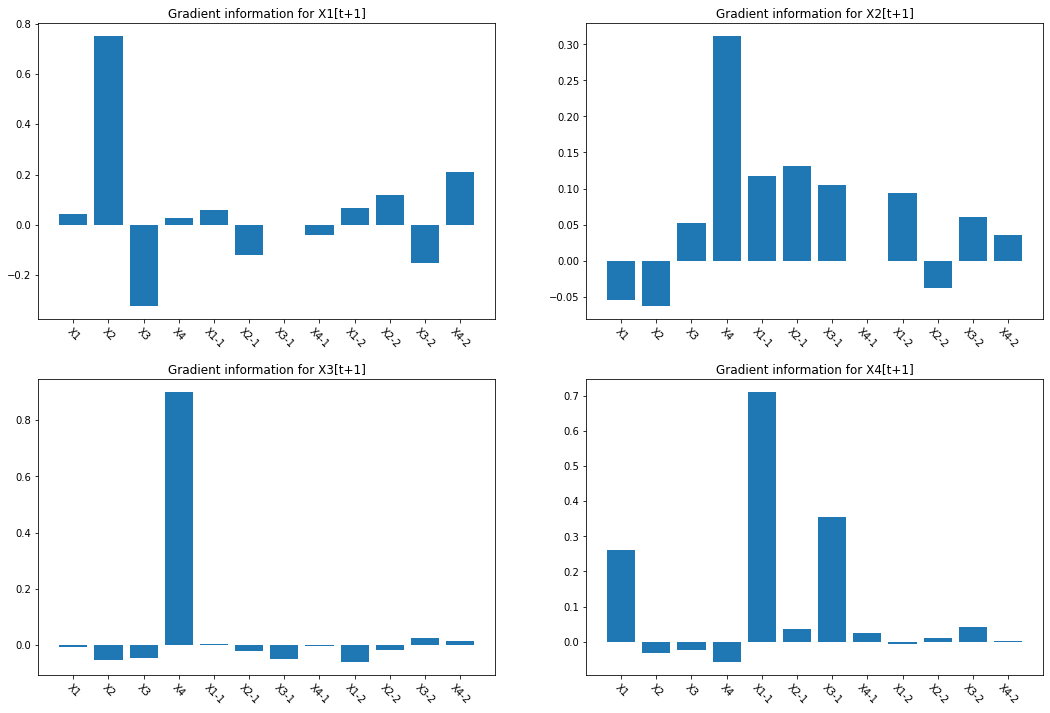

In [17]:
# Plot gradient results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

labels = list(test1.columns)
for i in range(1, 3):
  for col in test1.columns:
    labels.append(col + '-' + str(i))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].bar(labels, grad_info[i])
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)
  axs[i // 2, i % 2].set_title('Gradient information for X' + str(i + 1) + '[t+1]')

plt.show()

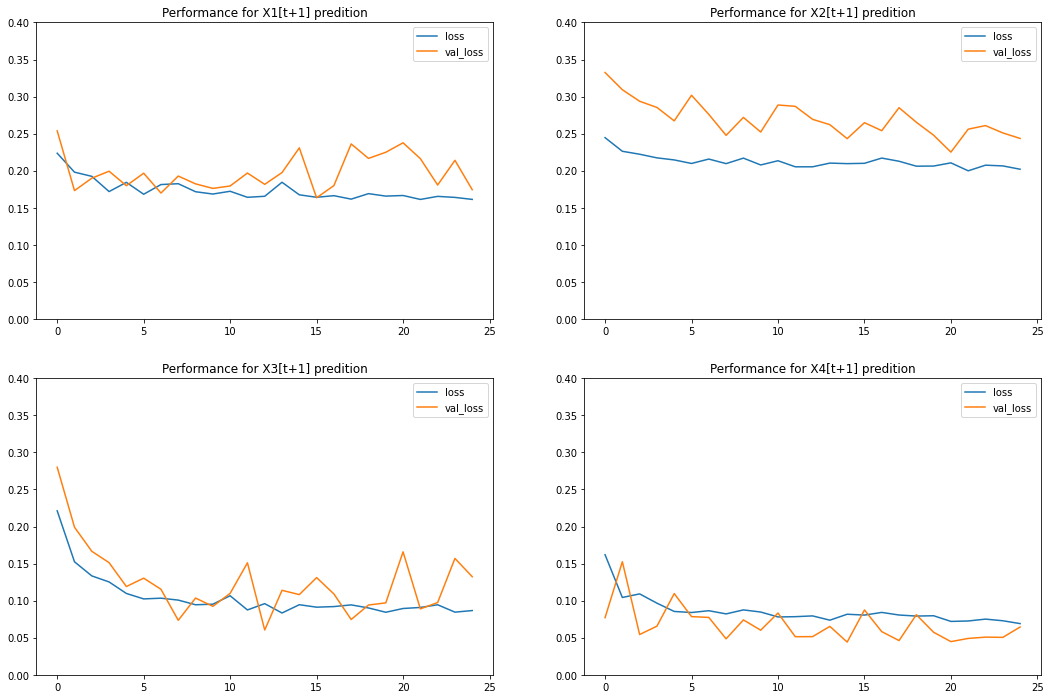

In [18]:
# Plot performance results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].plot(performances[i][0], label='loss')
  axs[i // 2, i % 2].plot(performances[i][1], label='val_loss')
  axs[i // 2, i % 2].set_title('Performance for X' + str(i + 1) + '[t+1] predition')
  axs[i // 2, i % 2].legend()
  axs[i // 2, i % 2].set_ylim(bottom=0, top=0.4)

plt.show()

Compare prediction of X1 and X2 performances with and without remaining variables

In [19]:
uni_performances = []

for el in ['X1', 'X2']:
  values = test1[el].values.reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(values)
  uni_x_train, uni_x_test, uni_y_train, uni_y_test = series_to_supervised(scaled, 2, 180)
  uni_x_train = np.reshape(uni_x_train.values, (uni_x_train.shape[0], 1, uni_x_train.shape[1]))
  uni_x_test = np.reshape(uni_x_test.values, (uni_x_test.shape[0], 1, uni_x_test.shape[1]))

  # Create current model
  model = keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=4, activation='elu', padding='same', input_shape=(uni_x_train.shape[1], uni_x_train.shape[2])),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='elu'),
    layers.Dense(units=1)
  ])
  model.compile(optimizer='adam', loss='mae')
  # model.summary()

  # Train model
  np.random.seed(42)
  tensorflow.random.set_seed(42)
  history = model.fit(uni_x_train, uni_y_train, epochs=25, batch_size=1, validation_data=(uni_x_test, uni_y_test), shuffle=False)
  uni_performances.append((history.history['loss'], history.history['val_loss']))

Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2100 - val_loss: 0.1668
Epoch 2/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1760 - val_loss: 0.1686
Epoch 3/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1748 - val_loss: 0.1720
Epoch 4/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1754 - val_loss: 0.1670
Epoch 5/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1657 - val_loss: 0.1778
Epoch 6/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1728 - val_loss: 0.1797
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1712 - val_loss: 0.1727
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1743 - val_loss: 0.1811
Epoch 9/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1639 - val_loss: 0.1815
Epoch 10/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1715 - val_loss: 0.1643

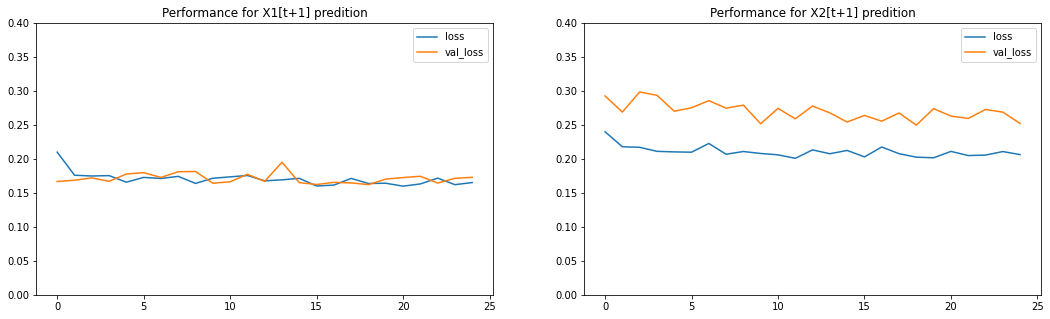

In [20]:
# Plot performance results
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

for i in range(2):
  axs[i].plot(uni_performances[i][0], label='loss')
  axs[i].plot(uni_performances[i][1], label='val_loss')
  axs[i].set_title('Performance for X' + str(i + 1) + '[t+1] predition')
  axs[i].legend()
  axs[i].set_ylim(bottom=0, top=0.4)

plt.show()

Neural Networks with Attention Mechanism

In [21]:
# Switch last two dimensions to be compatible with the Attention layer
attention_x_train = x_train.reshape((x_train.shape[0], x_train.shape[2], x_train.shape[1]))
attention_x_test = x_test.reshape((x_test.shape[0], x_test.shape[2], x_test.shape[1]))

In [22]:
attention_info = []
attention_performances = []

start_time = time.perf_counter()

for ind in range(len(test1.columns)):
  # Only the expected output (y_train and y_test) changes
  print('Current variable: X' + str(ind + 1))
  current_y_train = y_train[:, ind]
  current_y_test = y_test[:, ind]

  # Create current model
  model = keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=4, activation='elu', padding='same', input_shape=(attention_x_train.shape[1], attention_x_train.shape[2])),
    Attention(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='elu'),
    layers.Dense(units=1)
  ])
  model.compile(optimizer='adam', loss='mae')
  # model.summary()

  # Train model
  np.random.seed(42)
  tensorflow.random.set_seed(42)
  history = model.fit(attention_x_train, current_y_train, epochs=25, batch_size=1, validation_data=(attention_x_test, current_y_test), shuffle=False)

  # Obtain Attention information
  current = get_activations(model, attention_x_test)['attention_weight'].transpose()
  current = current.reshape(current.shape[0], current.shape[1])
  current = current.mean(axis=1)
  current = current.transpose()
  attention_info.append(current)
  attention_performances.append((history.history['loss'], history.history['val_loss']))

end_time_attention_linear = time.perf_counter() - start_time
times['attention_linear'] = end_time_attention_linear

Current variable: X1
Epoch 1/25
180/180 [==============================] - 2s 5ms/step - loss: 0.2469 - val_loss: 0.4256
Epoch 2/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2519 - val_loss: 0.4395
Epoch 3/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2552 - val_loss: 0.4200
Epoch 4/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2493 - val_loss: 0.4263
Epoch 5/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2381 - val_loss: 0.4279
Epoch 6/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2386 - val_loss: 0.4252
Epoch 7/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2355 - val_loss: 0.4462
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.2379 - val_loss: 0.4176
Epoch 9/25
180/180 [==============================] - 1s 3ms/step - loss: 0.2391 - val_loss: 0.4193
Epoch 10/25
180/180 [==============================] - 1s 4ms/step - loss: 0.23

180/180 [==============================] - 1s 4ms/step - loss: 0.1705 - val_loss: 0.1955
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1618 - val_loss: 0.2563
Epoch 8/25
180/180 [==============================] - 1s 4ms/step - loss: 0.1702 - val_loss: 0.1943
Epoch 9/25
180/180 [==============================] - 1s 4ms/step - loss: 0.1630 - val_loss: 0.1987
Epoch 10/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1592 - val_loss: 0.1909
Epoch 11/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1692 - val_loss: 0.2062
Epoch 12/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1618 - val_loss: 0.1915
Epoch 13/25
180/180 [==============================] - 1s 4ms/step - loss: 0.1645 - val_loss: 0.2032
Epoch 14/25
180/180 [==============================] - 1s 4ms/step - loss: 0.1633 - val_loss: 0.2273
Epoch 15/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1669 - val_loss: 0.1973
Epoch

<ipython-input-23-9d3dddfb2692>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)


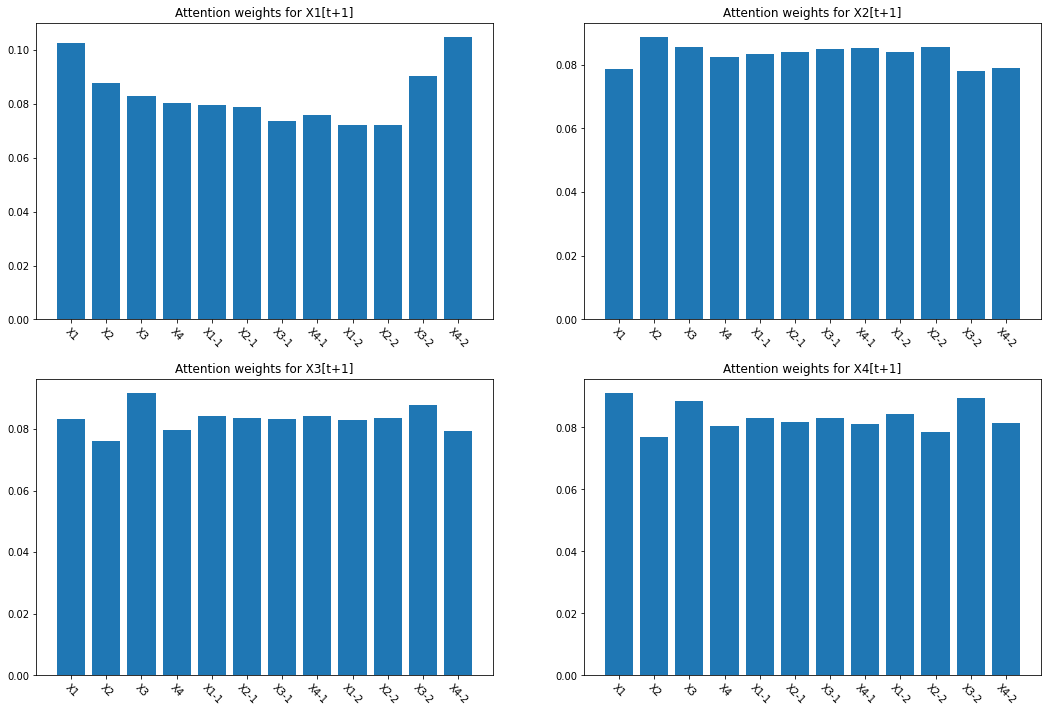

In [23]:
# Plot gradient results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

labels = list(test1.columns)
for i in range(1, 3):
  for col in test1.columns:
    labels.append(col + '-' + str(i))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].bar(labels, attention_info[i])
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)
  axs[i // 2, i % 2].set_title('Attention weights for X' + str(i + 1) + '[t+1]')

plt.show()

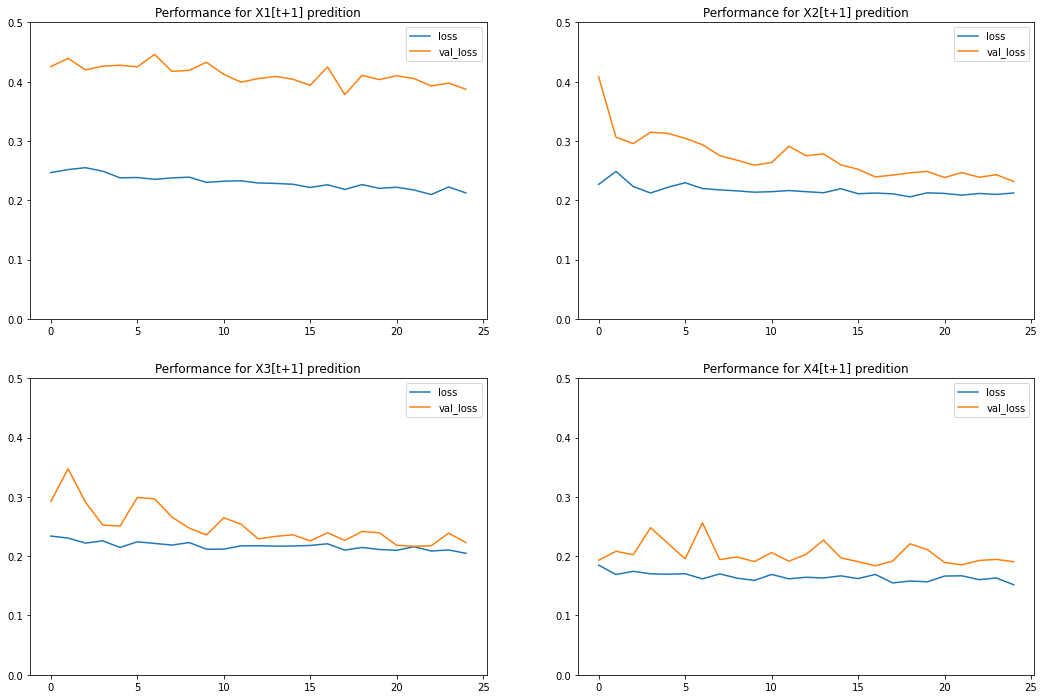

In [24]:
# Plot performance results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].plot(attention_performances[i][0], label='loss')
  axs[i // 2, i % 2].plot(attention_performances[i][1], label='val_loss')
  axs[i // 2, i % 2].set_title('Performance for X' + str(i + 1) + '[t+1] predition')
  axs[i // 2, i % 2].legend()
  axs[i // 2, i % 2].set_ylim(bottom=0, top=0.5)

plt.show()

RNN Gaussian DyBM

In [25]:
from pydybm.time_series.rnn_gaussian_dybm import RNNGaussianDyBM
from pydybm.base.sgd import RMSProp
from pydybm.base.generator import *

In [26]:
def dybm_preprocess(data, split):
    values = data.values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(values)
    scaled_tr, scaled_ts = scaled[:split], scaled[split:-1]
    dybm_tr = SequenceGenerator(scaled_tr)
    dybm_ts = SequenceGenerator(scaled_ts)
    return dybm_tr, dybm_ts

In [27]:
dybm_tr, dybm_ts = dybm_preprocess(test1, 180)

In [28]:
def RMSE(y_true, y_pred):
    y1 = y_true.flatten()
    y2 = y_pred.flatten()
    total = np.sum((y1 - y2) ** 2) / len(y1)
    return np.sqrt(total)

def MAE(y_true, y_pred):
    y1 = y_true.flatten()
    y2 = y_pred.flatten()
    total = np.sum(np.abs(y1 - y2)) / len(y1)
    return total

def MAE_by_var(y_true, y_pred):
    errors = []
    for i in range(y_true.shape[1]):
        errors.append(round(MAE(y_true[:, i], y_pred[:, i]), 5))
    return errors

In [29]:
in_dim = test1.shape[1]
out_dim = test1.shape[1]
rnn_dim = 10
max_iter = 20
SGD = RMSProp

delay = 5
decay = 0.5
sparsity = 0.5
spectral_radius = 0.95
leak = 0.5
learning_rate = 0.0005
random_seed = 2

In [30]:
dybm_model = RNNGaussianDyBM(in_dim,out_dim,rnn_dim,spectral_radius,sparsity,delay=delay,
                        decay_rates =[decay],leak=leak, random_seed = random_seed, SGD=SGD())  
dybm_model.set_learning_rate(learning_rate)

In [31]:
start_time = time.perf_counter()

for i in range(max_iter):
    dybm_model.init_state()
    dybm_tr.reset(i)
    result = dybm_model.learn(dybm_tr, get_result=True)
    errors = MAE_by_var(np.array(result["actual"]), np.array(result["prediction"]))
    dybm_iter_output = 'Iteration ' + str(i + 1) + ' MAE: '
    for j in range(len(errors)):
        dybm_iter_output += 'X' + str(j + 1) + ': ' + str(errors[j]) + ' - '
    print(dybm_iter_output)
    
end_time_dybm_linear = time.perf_counter() - start_time
times['dybm_linear'] = end_time_dybm_linear

Iteration 1 MAE: X1: 0.23434 - X2: 0.23626 - X3: 0.24628 - X4: 0.2231 - 
Iteration 2 MAE: X1: 0.21497 - X2: 0.20581 - X3: 0.1925 - X4: 0.15421 - 
Iteration 3 MAE: X1: 0.20021 - X2: 0.19987 - X3: 0.17301 - X4: 0.12948 - 
Iteration 4 MAE: X1: 0.18935 - X2: 0.19802 - X3: 0.15934 - X4: 0.11235 - 
Iteration 5 MAE: X1: 0.18118 - X2: 0.19677 - X3: 0.14699 - X4: 0.09677 - 
Iteration 6 MAE: X1: 0.17509 - X2: 0.19587 - X3: 0.13525 - X4: 0.08299 - 
Iteration 7 MAE: X1: 0.17014 - X2: 0.19524 - X3: 0.12393 - X4: 0.07134 - 
Iteration 8 MAE: X1: 0.16612 - X2: 0.19474 - X3: 0.11334 - X4: 0.06203 - 
Iteration 9 MAE: X1: 0.16287 - X2: 0.1943 - X3: 0.10363 - X4: 0.05531 - 
Iteration 10 MAE: X1: 0.16013 - X2: 0.194 - X3: 0.0946 - X4: 0.05043 - 
Iteration 11 MAE: X1: 0.15805 - X2: 0.19377 - X3: 0.08617 - X4: 0.04696 - 
Iteration 12 MAE: X1: 0.15663 - X2: 0.19356 - X3: 0.07866 - X4: 0.04469 - 
Iteration 13 MAE: X1: 0.15554 - X2: 0.19337 - X3: 0.07223 - X4: 0.0432 - 
Iteration 14 MAE: X1: 0.15466 - X2: 0.193

In [32]:
def process_dybm_results(weights):
    labels = ['X' + str(i) for i in range(1, weights.shape[0] + 1)]
    for i in range(1, weights.shape[0]):
        labels += ['X' + str(j) + '-' + str(i) for j in range(1, weights.shape[0] + 1)]
    
    params = {'labels': labels}
    for i in range(weights.shape[2]):
        vals = weights[:, :, i].flatten()
        params['X' + str(i + 1)] = vals
    
    return params

In [33]:
# Obtain weights before Test set
dybm_weights = process_dybm_results(dybm_model.variables['W'])

In [34]:
# Similar to dybm.learn, but without parameter updates
def test_dybm(model, test_set):
    preds = []
    est = []
    for in_p in test_set:
        out_p = in_p
        pred = model.predict_next()
        preds.append(pred)
        est.append(out_p)
        model._update_state(in_p)
    return preds, est

In [35]:
dybm_ts.reset(0)
preds, est = test_dybm(dybm_model, dybm_ts)
y_errors = MAE_by_var(np.array(preds), np.array(est))

In [36]:
dybm_y_output = ''
for j in range(len(y_errors)):
    dybm_y_output += 'X' + str(j + 1) + ': ' + str(y_errors[j]) + ' - '
print(dybm_y_output)

X1: 0.1777 - X2: 0.23245 - X3: 0.05828 - X4: 0.0454 - 


<ipython-input-37-9d164ed26851>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(dybm_weights['labels'], rotation=-45)


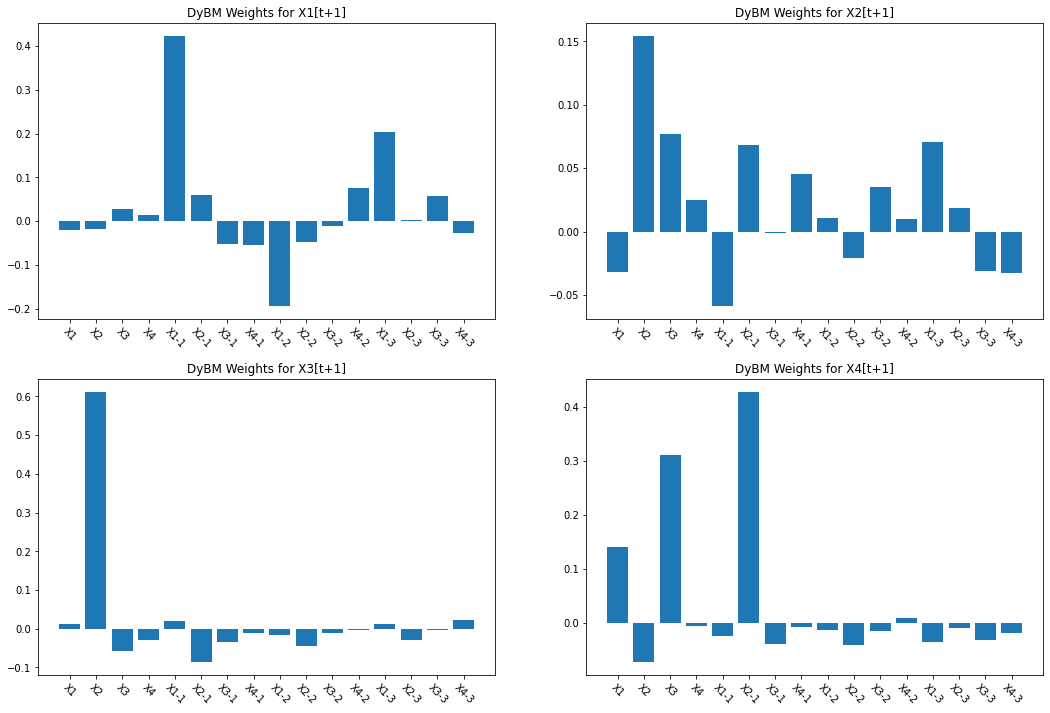

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].bar(dybm_weights['labels'], dybm_weights['X' + str(i + 1)])
  axs[i // 2, i % 2].set_xticklabels(dybm_weights['labels'], rotation=-45)
  axs[i // 2, i % 2].set_title('DyBM Weights for X' + str(i + 1) + '[t+1]')

plt.show()

Second Dataset: Nonlinear Dependencies

In [38]:
X3 = np.zeros(n)
X4 = np.zeros(n)

for i in range(1, n):
  X3[i] = 2 * math.exp(X2[i - 1] / 2) 
  X4[i] = math.exp(X3[i - 1] / 15) + math.exp(X1[i - 1]) ** 0.5

np.random.seed(0)

test2 = pandas.DataFrame()
test2['X1'] = X1
test2['X2'] = X2
# Add noise to prevent perfect predictions
test2['X3'] = X3 + np.random.normal(0, 1, n)
# Add noise to prevent perfect predictions
test2['X4'] = X4 + np.random.normal(0, 1, n)

test2_no_noise = pandas.DataFrame(np.array([X1, X2, X3, X4]).transpose(), columns=['X' + str(i) for i in range(1, 5)])

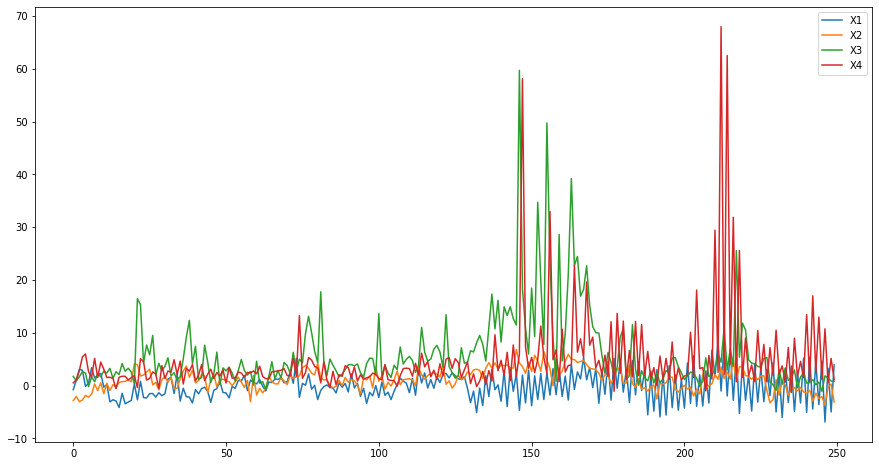

In [39]:
test2.plot(figsize=(15, 8))
plt.show()

In [40]:
adf_test(test2)
test2 = test2.diff().dropna()

-----------------
X1
ADF Value: -4.012514918301403
P-Value: 0.0013463787375262493
Critical Values:
1% -3.457437824930831
5% -2.873459364726563
10% -2.573122099570008
-----------------
X2
ADF Value: -3.0491585331735247
P-Value: 0.030551712493302078
Critical Values:
1% -3.457215237265747
5% -2.873361841566324
10% -2.5730700760129555
-----------------
X3
ADF Value: -2.129350243923848
P-Value: 0.23287763553131413
Critical Values:
1% -3.458010773719797
5% -2.8737103617125186
10% -2.5732559963936206
-----------------
X4
ADF Value: -3.64316572798801
P-Value: 0.004987436257063974
Critical Values:
1% -3.458010773719797
5% -2.8737103617125186
10% -2.5732559963936206


Granger Causality (Exhaustive Approach)

In [41]:
start_time = time.perf_counter()

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  matrix = granger_causality_matrix(test2, maxlag=1)
  filtered_matrix = filter_causality_matrix(matrix, 0.05)

end_time_granger_nonlinear = time.perf_counter() - start_time
times['granger_nonlinear'] = end_time_granger_nonlinear

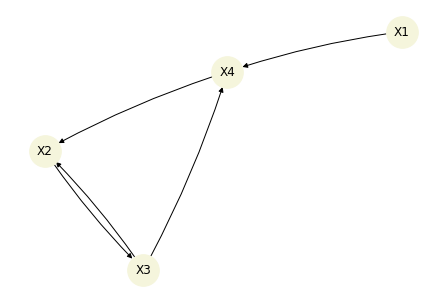

In [42]:
graph_from_matrix(filtered_matrix, ['X1', 'X2', 'X3', 'X4'])

PCMCI (with CMIknn)

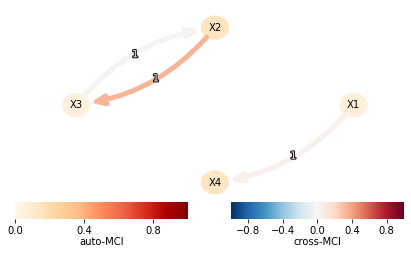

In [43]:
dataframe_2 = pp.DataFrame(test2.values, datatime=np.arange(len(test2)))


start_time = time.perf_counter()

cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe_2,
    cond_ind_test = cmi_knn,
    verbosity=0
)

results = pcmci_cmi_knn.run_pcmci(tau_max=20, pc_alpha=0.05)
link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=results['p_matrix'],
                                                     val_matrix=results['val_matrix'],
                                                     alpha_level=0.01)['link_matrix']

end_time_pcmci_nonlinear = time.perf_counter() - start_time
times['pcmci_nonlinear'] = end_time_pcmci_nonlinear

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=['X1', 'X2', 'X3', 'X4'],
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
)

plt.show()

Neural Networks with Gradient Information

In [44]:
values = test2.values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

x_train, x_test, y_train, y_test = series_to_supervised(scaled, 2, 180)

x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))
y_train = y_train.values
y_test = y_test.values

In [45]:
grad_info_2 = []
performances_2 = []

start_time = time.perf_counter()

for ind in range(len(test1.columns)):
  # Only the expected output (y_train and y_test) changes
  print('Current variable: X' + str(ind + 1))
  current_y_train = y_train[:, ind]
  current_y_test = y_test[:, ind]

  # Create current model
  model = keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=4, activation='elu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2])),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='elu'),
    layers.Dense(units=1)
  ])
  model.compile(optimizer='adam', loss='mae')
  # model.summary()

  # Train model
  np.random.seed(42)
  tensorflow.random.set_seed(42)
  history = model.fit(x_train, current_y_train, epochs=25, batch_size=1, validation_data=(x_test, current_y_test), shuffle=False)

  # Obtain gradient information
  inp = tensorflow.Variable(x_test, dtype=tensorflow.float32)
  model(inp)

  with tensorflow.GradientTape() as tape:
      predictions = model(inp)
    
  grads = tape.gradient(predictions, inp)
  grads = tensorflow.reduce_mean(grads, axis=1).numpy()[0]

  grad_info_2.append(grads)
  performances_2.append((history.history['loss'], history.history['val_loss']))

end_time_gradient_info_nonlinear = time.perf_counter() - start_time
times['gradient_info_nonlinear'] = end_time_gradient_info_nonlinear

Current variable: X1
Epoch 1/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1600 - val_loss: 0.1454
Epoch 2/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1441 - val_loss: 0.1164
Epoch 3/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1352 - val_loss: 0.1426
Epoch 4/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1412 - val_loss: 0.1222
Epoch 5/25
180/180 [==============================] - 3600s 20s/step - loss: 0.1349 - val_loss: 0.1333
Epoch 6/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1394 - val_loss: 0.1519
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1318 - val_loss: 0.1239
Epoch 8/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1386 - val_loss: 0.1453
Epoch 9/25
180/180 [==============================] - 0s 3ms/step - loss: 0.1396 - val_loss: 0.1547
Epoch 10/25
180/180 [==============================] - 0s 3ms/step - loss: 0

180/180 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.1000
Epoch 7/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0843
Epoch 8/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0816
Epoch 9/25
180/180 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.0855
Epoch 10/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0877
Epoch 11/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0913
Epoch 12/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0902
Epoch 13/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0790
Epoch 14/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0703
Epoch 15/25
180/180 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0823
Epoch

<ipython-input-46-cd88a5c28fee>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)


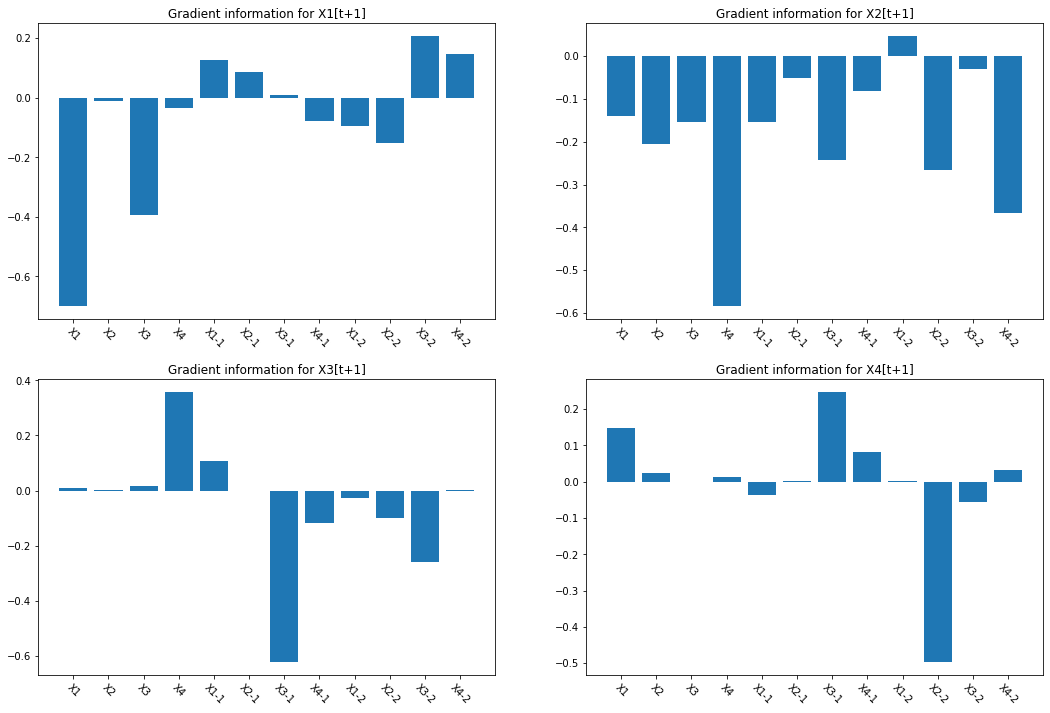

In [46]:
# Plot gradient results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

labels = list(test2.columns)
for i in range(1, 3):
  for col in test2.columns:
    labels.append(col + '-' + str(i))

for i in range(len(test2.columns)):
  axs[i // 2, i % 2].bar(labels, grad_info_2[i])
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)
  axs[i // 2, i % 2].set_title('Gradient information for X' + str(i + 1) + '[t+1]')

plt.show()

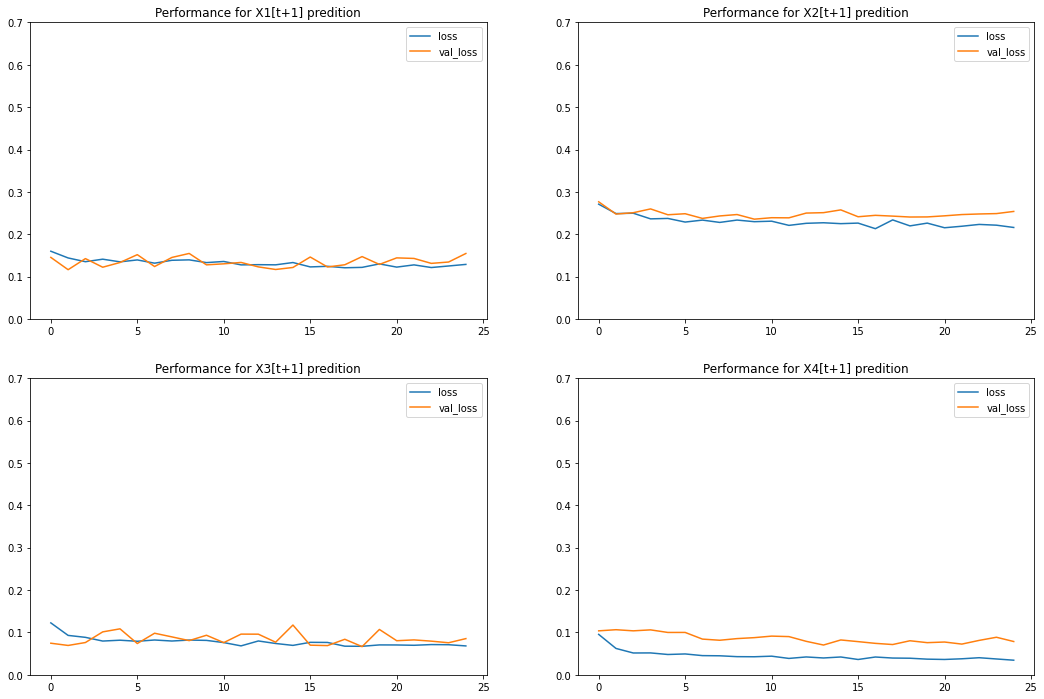

In [47]:
# Plot performance results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].plot(performances_2[i][0], label='loss')
  axs[i // 2, i % 2].plot(performances_2[i][1], label='val_loss')
  axs[i // 2, i % 2].set_title('Performance for X' + str(i + 1) + '[t+1] predition')
  axs[i // 2, i % 2].legend()
  axs[i // 2, i % 2].set_ylim(bottom=0, top=0.7)

plt.show()

Neural Networks with Attention Mechanism

In [48]:
# Switch last two dimensions to be compatible with the Attention layer
attention_x_train = x_train.reshape((x_train.shape[0], x_train.shape[2], x_train.shape[1]))
attention_x_test = x_test.reshape((x_test.shape[0], x_test.shape[2], x_test.shape[1]))

In [49]:
attention_info_2 = []
attention_performances_2 = []

start_time = time.perf_counter()

for ind in range(len(test1.columns)):
  # Only the expected output (y_train and y_test) changes
  print('Current variable: X' + str(ind + 1))
  current_y_train = y_train[:, ind]
  current_y_test = y_test[:, ind]

  # Create current model
  model = keras.models.Sequential([
    layers.Conv1D(filters=32, kernel_size=4, activation='elu', padding='same', input_shape=(attention_x_train.shape[1], attention_x_train.shape[2])),
    Attention(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=32, activation='elu'),
    layers.Dense(units=1)
  ])
  model.compile(optimizer='adam', loss='mae')
  # model.summary()

  # Train model
  np.random.seed(42)
  tensorflow.random.set_seed(42)
  history = model.fit(attention_x_train, current_y_train, epochs=25, batch_size=1, validation_data=(attention_x_test, current_y_test), shuffle=False)

  # Obtain Attention information
  current = get_activations(model, attention_x_test)['attention_weight'].transpose()
  current = current.reshape(current.shape[0], current.shape[1])
  current = current.mean(axis=1)
  current = current.transpose()
  attention_info_2.append(current)
  attention_performances_2.append((history.history['loss'], history.history['val_loss']))

end_time_attention_nonlinear = time.perf_counter() - start_time
times['attention_nonlinear'] = end_time_attention_nonlinear

Current variable: X1
Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2029 - val_loss: 0.3789
Epoch 2/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1925 - val_loss: 0.3239
Epoch 3/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1728 - val_loss: 0.2261
Epoch 4/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1526 - val_loss: 0.2741
Epoch 5/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1531 - val_loss: 0.1511
Epoch 6/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1465 - val_loss: 0.1642
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1394 - val_loss: 0.1940
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.1546 - val_loss: 0.1687
Epoch 9/25
180/180 [==============================] - 1s 4ms/step - loss: 0.1330 - val_loss: 0.1504
Epoch 10/25
180/180 [==============================] - 1s 3ms/step - loss: 0.13

180/180 [==============================] - 1s 3ms/step - loss: 0.0505 - val_loss: 0.1261
Epoch 7/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0494 - val_loss: 0.1112
Epoch 8/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0498 - val_loss: 0.1072
Epoch 9/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0485 - val_loss: 0.1202
Epoch 10/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0499 - val_loss: 0.1147
Epoch 11/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0476 - val_loss: 0.1114
Epoch 12/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0493 - val_loss: 0.1193
Epoch 13/25
180/180 [==============================] - 1s 4ms/step - loss: 0.0482 - val_loss: 0.1146
Epoch 14/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0473 - val_loss: 0.1209
Epoch 15/25
180/180 [==============================] - 1s 3ms/step - loss: 0.0498 - val_loss: 0.1224
Epoch

<ipython-input-50-88edc3178029>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)


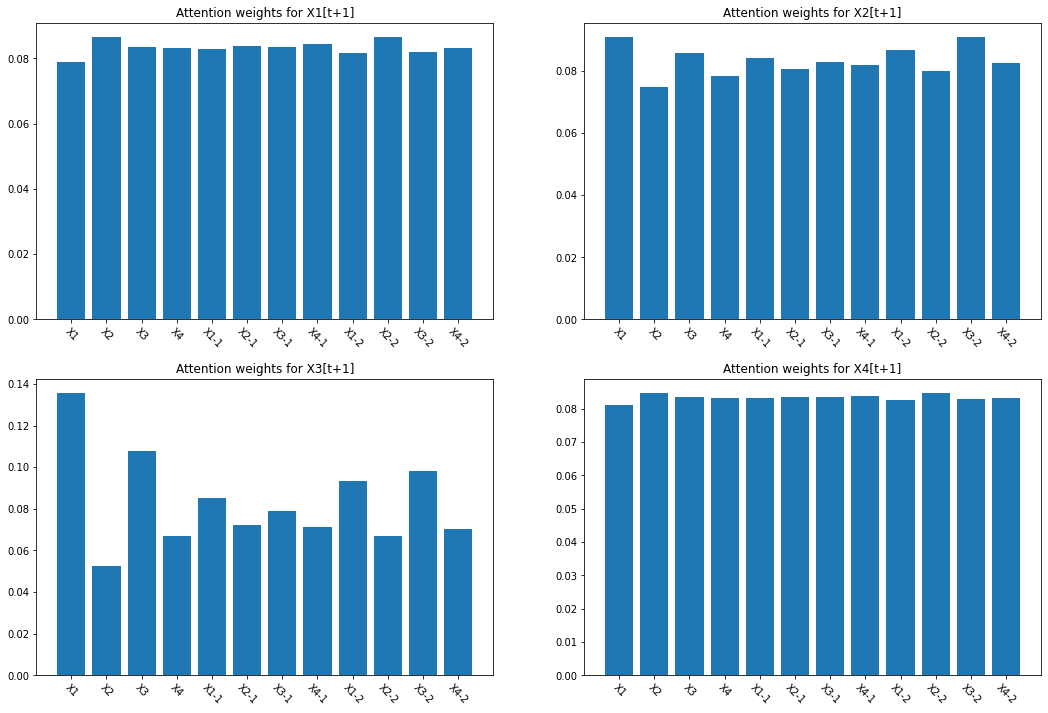

In [50]:
# Plot gradient results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

labels = list(test1.columns)
for i in range(1, 3):
  for col in test1.columns:
    labels.append(col + '-' + str(i))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].bar(labels, attention_info_2[i])
  axs[i // 2, i % 2].set_xticklabels(labels, rotation=-45)
  axs[i // 2, i % 2].set_title('Attention weights for X' + str(i + 1) + '[t+1]')

plt.show()

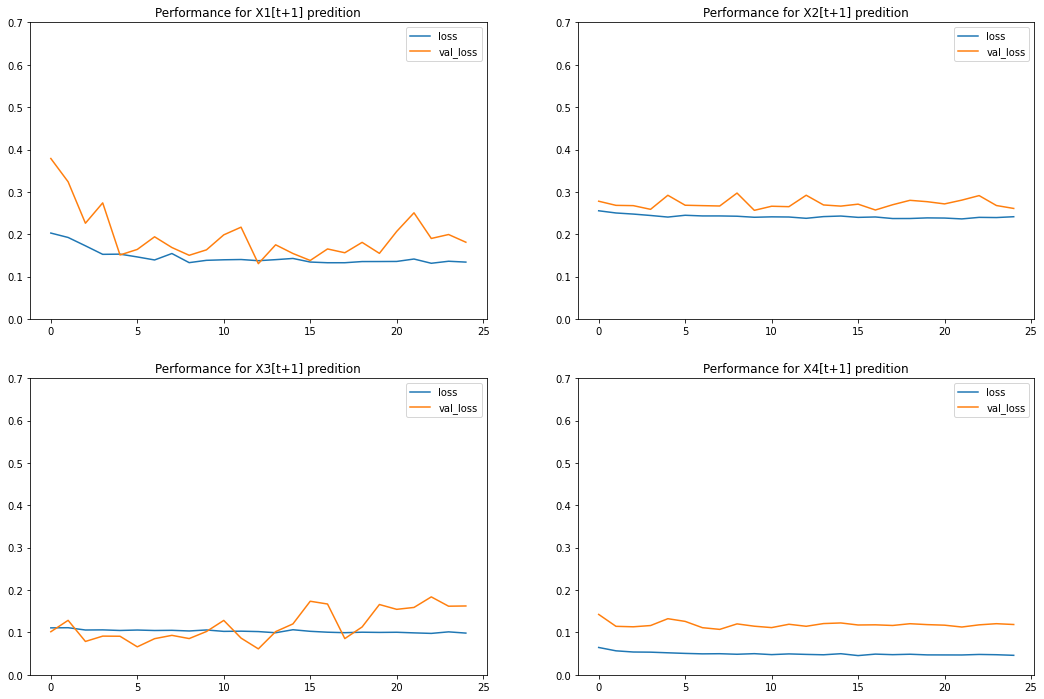

In [51]:
# Plot performance results
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].plot(attention_performances_2[i][0], label='loss')
  axs[i // 2, i % 2].plot(attention_performances_2[i][1], label='val_loss')
  axs[i // 2, i % 2].set_title('Performance for X' + str(i + 1) + '[t+1] predition')
  axs[i // 2, i % 2].legend()
  axs[i // 2, i % 2].set_ylim(bottom=0, top=0.7)

plt.show()

RNN Gaussian DyBM

In [52]:
dybm_tr, dybm_ts = dybm_preprocess(test2, 180)

In [53]:
in_dim = test2.shape[1]
out_dim = test2.shape[1]
rnn_dim = 10
max_iter = 20
SGD = RMSProp

delay = 5
decay = 0.5
sparsity = 0.5
spectral_radius = 0.95
leak = 0.5
learning_rate = 0.0005
random_seed = 2

In [54]:
dybm_model_2 = RNNGaussianDyBM(in_dim,out_dim,rnn_dim,spectral_radius,sparsity,delay=delay,
                        decay_rates =[decay],leak=leak, random_seed = random_seed, SGD=SGD())  
dybm_model_2.set_learning_rate(learning_rate)

In [55]:
start_time = time.perf_counter()

for i in range(max_iter):
    dybm_model_2.init_state()
    dybm_tr.reset(i)
    result = dybm_model_2.learn(dybm_tr, get_result=True)
    errors = MAE_by_var(np.array(result["actual"]), np.array(result["prediction"]))
    dybm_iter_output = 'Iteration ' + str(i + 1) + ' MAE: '
    for j in range(len(errors)):
        dybm_iter_output += 'X' + str(j + 1) + ': ' + str(errors[j]) + ' - '
    print(dybm_iter_output)

end_time_dybm_nonlinear = time.perf_counter() - start_time
times['dybm_nonlinear'] = end_time_dybm_nonlinear

Iteration 1 MAE: X1: 0.20769 - X2: 0.26999 - X3: 0.10332 - X4: 0.04496 - 
Iteration 2 MAE: X1: 0.17342 - X2: 0.2576 - X3: 0.08219 - X4: 0.04051 - 
Iteration 3 MAE: X1: 0.14807 - X2: 0.24824 - X3: 0.0759 - X4: 0.03952 - 
Iteration 4 MAE: X1: 0.13094 - X2: 0.2418 - X3: 0.07229 - X4: 0.03877 - 
Iteration 5 MAE: X1: 0.12104 - X2: 0.23728 - X3: 0.07009 - X4: 0.03809 - 
Iteration 6 MAE: X1: 0.11674 - X2: 0.23334 - X3: 0.06877 - X4: 0.0375 - 
Iteration 7 MAE: X1: 0.11452 - X2: 0.22995 - X3: 0.06818 - X4: 0.03697 - 
Iteration 8 MAE: X1: 0.1134 - X2: 0.22698 - X3: 0.06762 - X4: 0.03651 - 
Iteration 9 MAE: X1: 0.1127 - X2: 0.22439 - X3: 0.06713 - X4: 0.03608 - 
Iteration 10 MAE: X1: 0.11215 - X2: 0.2222 - X3: 0.06672 - X4: 0.03568 - 
Iteration 11 MAE: X1: 0.11163 - X2: 0.22047 - X3: 0.06633 - X4: 0.0353 - 
Iteration 12 MAE: X1: 0.11115 - X2: 0.21893 - X3: 0.06593 - X4: 0.03492 - 
Iteration 13 MAE: X1: 0.11083 - X2: 0.21756 - X3: 0.06555 - X4: 0.0346 - 
Iteration 14 MAE: X1: 0.11057 - X2: 0.21635

In [56]:
# Obtain weights before Test set
dybm_weights_2 = process_dybm_results(dybm_model_2.variables['W'])

In [57]:
dybm_ts.reset(0)
preds, est = test_dybm(dybm_model_2, dybm_ts)
y_errors = MAE_by_var(np.array(preds), np.array(est))

In [58]:
dybm_y_output = ''
for j in range(len(y_errors)):
    dybm_y_output += 'X' + str(j + 1) + ': ' + str(y_errors[j]) + ' - '
print(dybm_y_output)

X1: 0.1329 - X2: 0.24877 - X3: 0.0626 - X4: 0.07667 - 


<ipython-input-59-85d08d3ad4a7>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i // 2, i % 2].set_xticklabels(dybm_weights_2['labels'], rotation=-45)


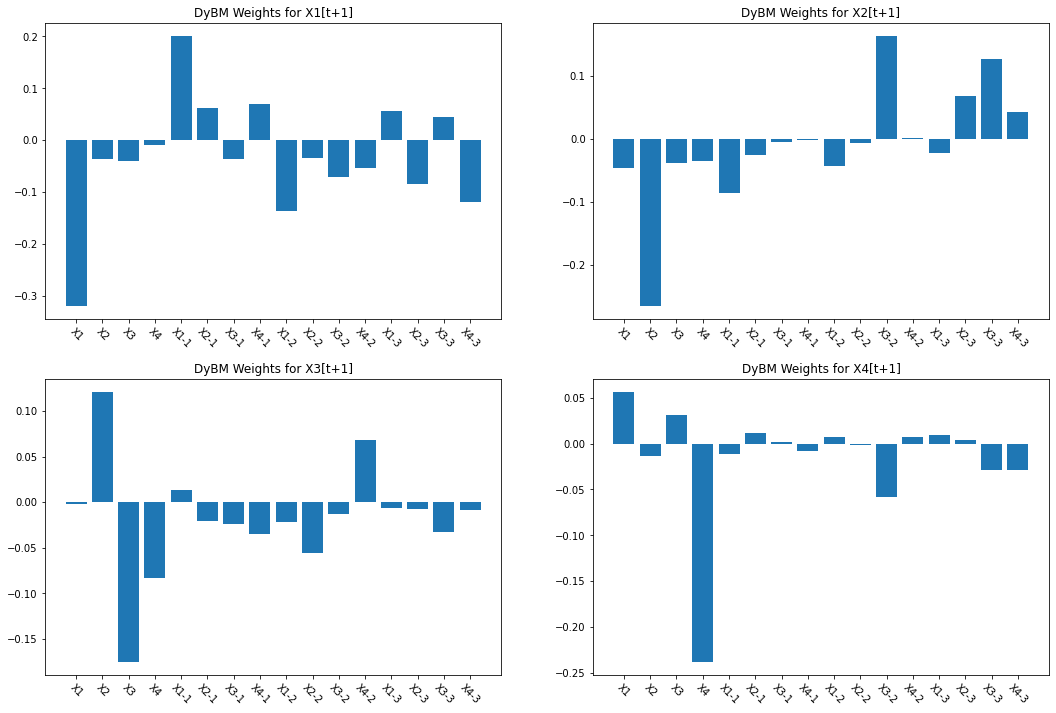

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for i in range(len(test1.columns)):
  axs[i // 2, i % 2].bar(dybm_weights_2['labels'], dybm_weights_2['X' + str(i + 1)])
  axs[i // 2, i % 2].set_xticklabels(dybm_weights_2['labels'], rotation=-45)
  axs[i // 2, i % 2].set_title('DyBM Weights for X' + str(i + 1) + '[t+1]')

plt.show()

Execution Times

pcmci_linear 3.3986299429998326
granger_linear 0.3536582010001439
gradient_info_linear 84.3799513920003
attention_linear 85.36950995299958
dybm_linear 2.678627190000043
granger_nonlinear 0.12263010700007726
pcmci_nonlinear 3734.493087968999
gradient_info_nonlinear 84.61392332700052
attention_nonlinear 85.33790332599892
dybm_nonlinear 2.252589278999949


<ipython-input-60-e75b145b70ad>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_labels, rotation=-45)


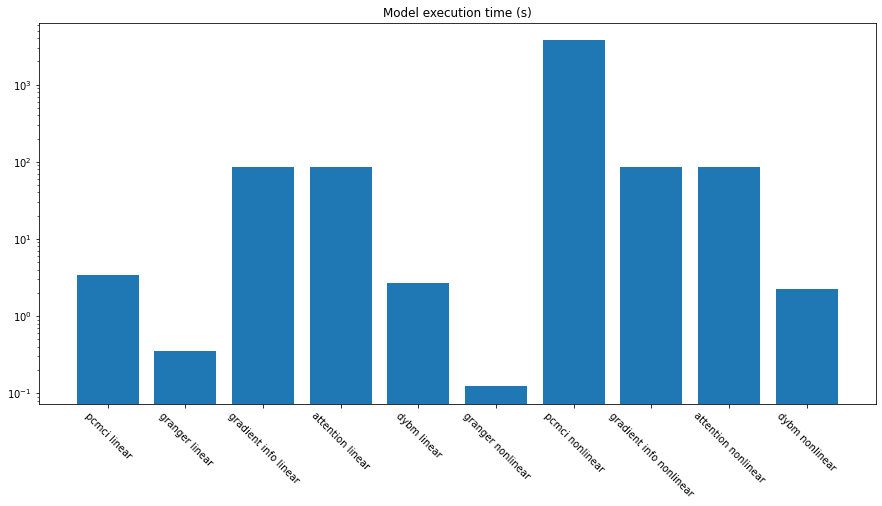

In [60]:
model_labels = []
model_times_vals = []
for key in times.keys():
    model_labels.append(' '.join(key.split('_')))
    model_times_vals.append(times[key])

for key in times.keys():
    print(key, times[key])
    
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(model_labels, model_times_vals)
ax.set_yscale('log')
ax.set_title('Model execution time (s)')
ax.set_xticklabels(model_labels, rotation=-45)
plt.show()